Exploring portfolio diversification and risk in Indian markets using Python.


Pulling 5 years of price data for a bunch of Indian stocks and ETFs from Yahoo Finance.
I’m using "yfinance" which is super simple and reliable for this stuff.

In [2]:
!pip install yfinance pandas numpy matplotlib scipy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# Assets
tickers = ['^NSEI', 'GOLDBEES.NS', 'INFY.NS', 'TATAMOTORS.NS', 'RELIANCE.NS', 'TITAN.NS']

# Fetching 5 years of data
data = yf.download(tickers, start='2019-10-01', end='2024-10-01')

# Handle multi-level columns returned by yfinance
if isinstance(data.columns, pd.MultiIndex):
    # Try to get 'Adj Close', if not available, get 'Close'
    try:
        data = data['Adj Close']
    except KeyError:
        print("Warning: 'Adj Close' not found, using 'Close' instead.")
        data = data['Close']

data.dropna(inplace=True)
display(data.tail())

/tmp/ipython-input-37564925.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2019-10-01', end='2024-10-01')
[*********************100%***********************]  6 of 6 completed

Ticker,GOLDBEES.NS,INFY.NS,RELIANCE.NS,TATAMOTORS.NS,TITAN.NS,^NSEI
Date,,,,,,
2024-09-24,62.990002,1851.179321,1483.450195,968.968933,3773.543457,25940.400391
2024-09-25,63.660000,1847.961914,1488.006958,955.385742,3726.036621,26004.150391
2024-09-26,63.770000,1852.788086,1491.991089,984.683899,3746.275635,26216.050781
2024-09-27,63.480000,1859.125854,1520.103882,984.535156,3805.248291,26178.949219
2024-09-30,63.549999,1828.753906,1470.701172,966.341614,3812.476318,25810.849609


Calculate daily log returns.
What'll be used for  all our risk and return metrics later.

In [3]:
log_returns = np.log(data / data.shift(1))
log_returns.dropna(inplace=True)
log_returns.tail()


Ticker,GOLDBEES.NS,INFY.NS,RELIANCE.NS,TATAMOTORS.NS,TITAN.NS,^NSEI
Date,,,,,,
2024-09-24,0.002862,0.001133,-0.002682,0.005644,-0.009257,0.000052
2024-09-25,0.010580,-0.001740,0.003067,-0.014117,-0.012669,0.002455
2024-09-26,0.001726,0.002608,0.002674,0.030205,0.005417,0.008116
2024-09-27,-0.004558,0.003415,0.018667,-0.000151,0.015619,-0.001416
2024-09-30,0.001102,-0.016472,-0.033039,-0.018652,0.001898,-0.014161


In [4]:
mean_returns = log_returns.mean() * 252  #Assuming 252 days in a trading year(standard assumption.)
cov_matrix = log_returns.cov() * 252

mean_returns, cov_matrix


(Ticker
 GOLDBEES.NS      0.136062
 INFY.NS          0.200919
 RELIANCE.NS      0.188698
 TATAMOTORS.NS    0.437799
 TITAN.NS         0.226724
 ^NSEI            0.167599
 dtype: float64,
 Ticker         GOLDBEES.NS   INFY.NS  RELIANCE.NS  TATAMOTORS.NS  TITAN.NS  \
 Ticker                                                                       
 GOLDBEES.NS       8.690413  0.010968    -0.035349      -0.025560  0.005908   
 INFY.NS           0.010968  0.084023     0.029243       0.041053  0.024287   
 RELIANCE.NS      -0.035349  0.029243     0.088246       0.052270  0.031383   
 TATAMOTORS.NS    -0.025560  0.041053     0.052270       0.204802  0.054305   
 TITAN.NS          0.005908  0.024287     0.031383       0.054305  0.085611   
 ^NSEI            -0.003444  0.033199     0.040325       0.051610  0.032485   
 
 Ticker            ^NSEI  
 Ticker                   
 GOLDBEES.NS   -0.003444  
 INFY.NS        0.033199  
 RELIANCE.NS    0.040325  
 TATAMOTORS.NS  0.051610  
 TITAN.NS       0

In [5]:
num_portfolios = 10000  #Simulate 10,000 random portfolios with random allocation.
results = np.zeros((3, num_portfolios))
weights_record = []

rf = 0.03  # 3% risk free rate (approx India 10Y bond)

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return','Volatility','Sharpe'])
results_df.head()


,Return,Volatility,Sharpe
0,0.238684,0.250203,0.834058
1,0.231515,0.656752,0.306836
2,0.212217,0.780356,0.233505
3,0.233979,0.348196,0.585818
4,0.184429,0.884740,0.174547


Scatter plot shows Efficient Frontier. The “curve” that balances return vs. risk.

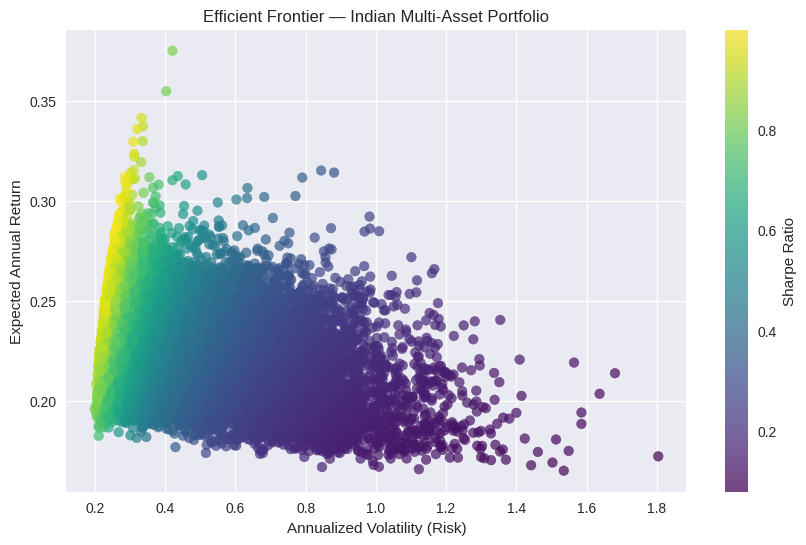

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier — Indian Multi-Asset Portfolio')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Expected Annual Return')
plt.show()


Isolating Key Portfolios:
* Max Sharpe (the one with best risk-adjusted return)
* Minimum Volatility (the safest one overall)


In [7]:
max_sharpe_idx = results_df['Sharpe'].idxmax()
min_vol_idx = results_df['Volatility'].idxmin()

max_sharpe_port = results_df.loc[max_sharpe_idx]
min_vol_port = results_df.loc[min_vol_idx]

print("Max Sharpe Portfolio Weights:")
print(pd.Series(weights_record[max_sharpe_idx], index=tickers).map('{:.2%}'.format))

print("\nMin Volatility Portfolio Weights:")
print(pd.Series(weights_record[min_vol_idx], index=tickers).map('{:.2%}'.format))


Max Sharpe Portfolio Weights:
^NSEI             0.54%
GOLDBEES.NS      28.91%
INFY.NS           5.44%
TATAMOTORS.NS    40.38%
RELIANCE.NS      23.92%
TITAN.NS          0.79%
dtype: object

Min Volatility Portfolio Weights:
^NSEI             1.06%
GOLDBEES.NS      21.10%
INFY.NS           7.72%
TATAMOTORS.NS     4.00%
RELIANCE.NS      15.83%
TITAN.NS         50.29%
dtype: object


Risk Measurement


In [8]:
max_sharpe_weights = np.array(weights_record[max_sharpe_idx])
portfolio_returns = (log_returns @ max_sharpe_weights)

VaR_99 = np.percentile(portfolio_returns, 1)
print(f"99% Historical VaR (daily): {VaR_99:.2%}")


99% Historical VaR (daily): -4.84%


Monte Carlo Simulation And Efficient Frontier

In [10]:
# Cell: setup + reproducibility
!pip install yfinance tqdm scipy --quiet

from tqdm.notebook import trange
import os

np.random.seed(42)   # Reproducible random portfolios.
plt.style.use('seaborn-v0_8')

# ensure results folder
os.makedirs('results', exist_ok=True)


In [11]:
#Monte Carlo simulation
num_portfolios = 10000   # good balance between speed & quality
tickers = list(data.columns)   # uses previously loaded 'data'
mean_returns = log_returns.mean() * 252
cov_matrix = log_returns.cov() * 252
rf = 0.03  # risk-free

results = np.zeros((3, num_portfolios))
weights_record = np.zeros((num_portfolios, len(tickers)))

for i in trange(num_portfolios, desc='Simulating portfolios'):
    w = np.random.random(len(tickers))
    w /= w.sum()
    weights_record[i, :] = w

    port_ret = np.dot(w, mean_returns)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    port_sharpe = (port_ret - rf) / port_vol

    results[0, i] = port_ret
    results[1, i] = port_vol
    results[2, i] = port_sharpe

results_df = pd.DataFrame(results.T, columns=['Return','Volatility','Sharpe'])
# attach tickers (optionally)
results_df['WeightsIndex'] = range(num_portfolios)


Simulating portfolios:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
results_df.to_csv('results/montecarlo_results.csv', index=False)
np.save('results/weights.npy', weights_record)
print("Saved results/montecarlo_results.csv and results/weights.npy")


Saved results/montecarlo_results.csv and results/weights.npy


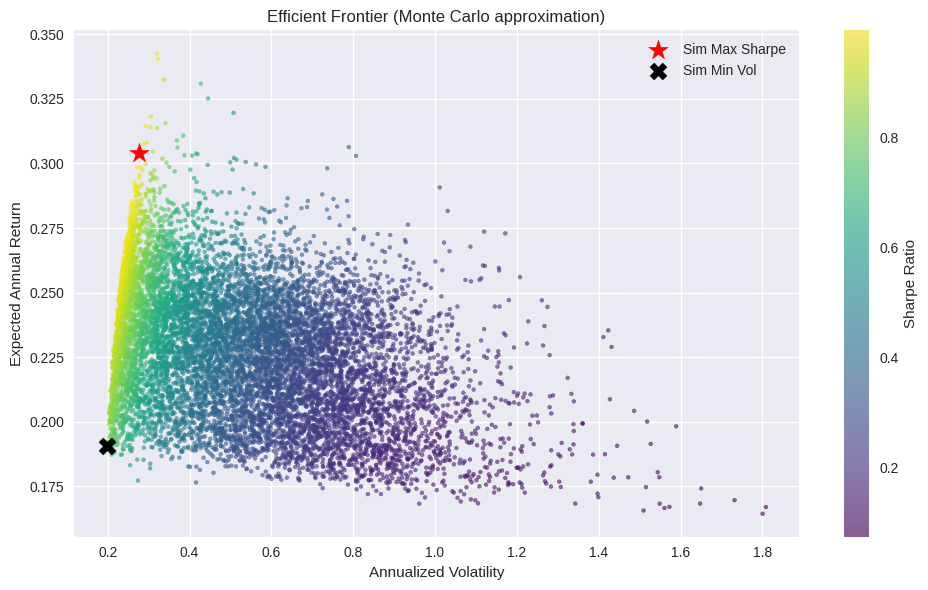

In [13]:
#Plot efficient frontier
idx_max_sharpe = results_df['Sharpe'].idxmax()
idx_min_vol = results_df['Volatility'].idxmin()

max_sharpe = results_df.loc[idx_max_sharpe]
min_vol = results_df.loc[idx_min_vol]

plt.figure(figsize=(10,6))
sc = plt.scatter(results_df['Volatility'], results_df['Return'],
                 c=results_df['Sharpe'], cmap='viridis', alpha=0.6, s=8)
plt.colorbar(sc, label='Sharpe Ratio')

# mark simulated points
plt.scatter(max_sharpe['Volatility'], max_sharpe['Return'], marker='*', color='red', s=220, label='Sim Max Sharpe')
plt.scatter(min_vol['Volatility'], min_vol['Return'], marker='X', color='black', s=150, label='Sim Min Vol')

plt.xlabel('Annualized Volatility')
plt.ylabel('Expected Annual Return')
plt.title('Efficient Frontier (Monte Carlo approximation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/efficient_frontier.png', dpi=150)
plt.show()


In [14]:
def show_weights(weights_array):
    return pd.Series(weights_array, index=tickers).map('{:.2%}'.format)

print("Simulated Max Sharpe Weights:\n", show_weights(weights_record[idx_max_sharpe]))
print("\nSimulated Min Vol Weights:\n", show_weights(weights_record[idx_min_vol]))


Simulated Max Sharpe Weights:
 GOLDBEES.NS       0.15%
INFY.NS          20.92%
RELIANCE.NS      14.12%
TATAMOTORS.NS    42.43%
TITAN.NS         19.90%
^NSEI             2.47%
dtype: object

Simulated Min Vol Weights:
 GOLDBEES.NS       0.01%
INFY.NS          27.86%
RELIANCE.NS       9.87%
TATAMOTORS.NS     0.59%
TITAN.NS         16.76%
^NSEI            44.91%
dtype: object


SciPy optimizers give us cleaner candidates (Tangency & GMV). Can be used later for VaR and risk reporting.

SciPy GMV weights:
 GOLDBEES.NS       0.43%
INFY.NS           7.19%
RELIANCE.NS       0.00%
TATAMOTORS.NS     0.00%
TITAN.NS          8.17%
^NSEI            84.20%
dtype: object

SciPy Tangency weights:
 GOLDBEES.NS       0.43%
INFY.NS          25.24%
RELIANCE.NS       7.22%
TATAMOTORS.NS    39.97%
TITAN.NS         27.14%
^NSEI             0.00%
dtype: object


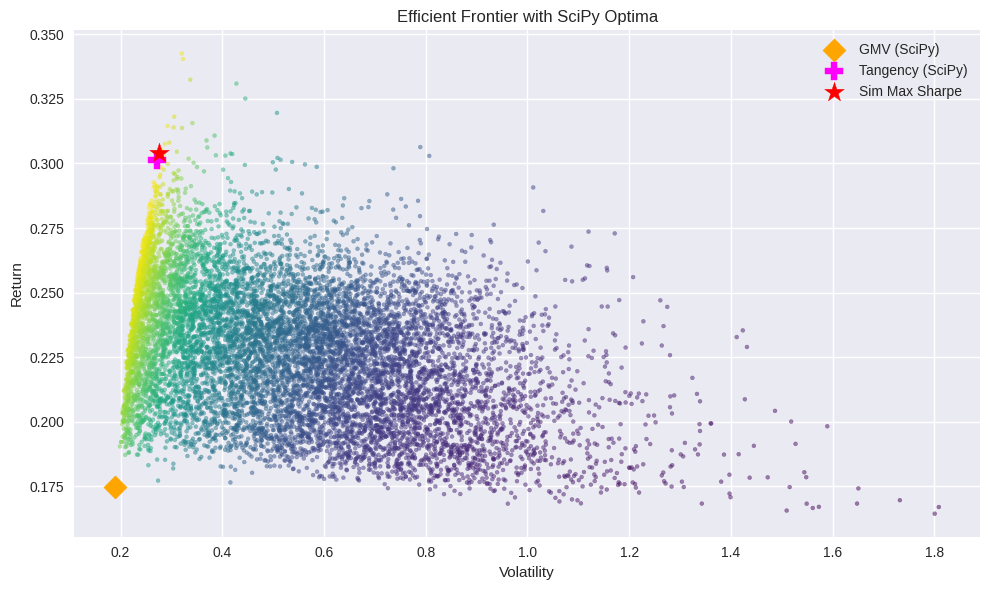

In [15]:
from scipy.optimize import minimize

num_assets = len(tickers)
bounds = tuple((0,1) for _ in range(num_assets))
cons = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})

def port_stats(w):
    ret = np.dot(w, mean_returns)
    vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    sharpe = (ret - rf) / vol
    return ret, vol, sharpe

# GMV
def vol_fun(w): return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
init = np.repeat(1/num_assets, num_assets)
res_gmv = minimize(vol_fun, init, method='SLSQP', bounds=bounds, constraints=cons)
w_gmv = res_gmv.x
ret_gmv, vol_gmv, sharpe_gmv = port_stats(w_gmv)

# Tangency (maximize Sharpe -> minimize negative Sharpe)
def neg_sharpe(w): return -port_stats(w)[2]
res_tan = minimize(neg_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
w_tan = res_tan.x
ret_tan, vol_tan, sharpe_tan = port_stats(w_tan)

print("SciPy GMV weights:\n", show_weights(w_gmv))
print("\nSciPy Tangency weights:\n", show_weights(w_tan))

# Add them to the plot (save again)
plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', alpha=0.5, s=8)
plt.scatter(vol_gmv, ret_gmv, marker='D', color='orange', s=140, label='GMV (SciPy)')
plt.scatter(vol_tan, ret_tan, marker='P', color='magenta', s=180, label='Tangency (SciPy)')
plt.scatter(max_sharpe['Volatility'], max_sharpe['Return'], marker='*', color='red', s=220, label='Sim Max Sharpe')
plt.legend()
plt.title('Efficient Frontier with SciPy Optima')
plt.xlabel('Volatility'); plt.ylabel('Return'); plt.grid(True)
plt.tight_layout()
plt.savefig('results/efficient_frontier_with_optima.png', dpi=150)
plt.show()


Set the seed to keep results reproducible. The Monte Carlo approach randomly samples allocations after 10k draws we get a good aproximation of the frontier.